In [6]:
from minisom import MiniSom
import os
import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt

Primero generamos datos del péndulo invertido

In [7]:
# CELDA 1: imports + generación / carga de dataset (guarda en .npz)
import os
import numpy as np
from scipy import signal, integrate
import matplotlib.pyplot as plt

# Ruta para guardar el dataset (modificá según convenga)
DATA_PATH = "pendulum_dataset.npz"

def gen_linear_trajectories_from_tf(num_traj=500, t_final=1.0, dt=0.005,
                                    ic_std=(1e-2,1e-2), pulse_prob=0.4, thresh=1e2):
    """Genera trayectorias desde G(s)=1/(s^2-9) en espacio de estados. Devuelve array (N,2)."""
    num = [1.0]
    den = [1.0, 0.0, -9.0]
    sys = signal.TransferFunction(num, den).to_ss()
    t = np.arange(0, t_final+dt, dt)
    all_data = []
    for _ in range(num_traj):
        x0 = np.random.randn(2) * np.array(ic_std)
        if np.random.rand() < pulse_prob:
            u = np.zeros_like(t)
            start = np.random.randint(0, len(t)//2)
            dur = np.random.randint(1, max(2, int(0.05/dt)))
            amp = np.random.randn() * 1.0
            u[start:start+dur] = amp
        else:
            u = np.zeros_like(t)
        try:
            tout, yout, xout = signal.lsim(sys, U=u, T=t, X0=x0)
        except Exception:
            A,B,C,D = sys.A, sys.B, sys.C, sys.D
            x = np.zeros((len(t),2))
            x[0,:] = x0
            for i in range(1,len(t)):
                xdot = A.dot(x[i-1,:]) + B.flatten()*u[i-1]
                x[i,:] = x[i-1,:] + xdot*dt
            xout = x
        all_data.append(xout)
    all_data = np.vstack(all_data)
    mask = np.all(np.abs(all_data) < thresh, axis=1)
    return all_data[mask,:]

def gen_nonlinear_trajectories(num_traj=500, t_final=1.0, dt=0.005, ic_std=(1e-2,1e-2), thresh=1e2):
    """Modelo no lineal: phi'' = (g/l)*sin(phi) + u(t) con g/l=9."""
    g_over_l = 9.0
    t_eval = np.arange(0, t_final+dt, dt)
    all_data = []
    def dyn(t,x,u_func):
        u = u_func(t)
        return np.array([x[1], g_over_l*np.sin(x[0]) + u])
    for _ in range(num_traj):
        x0 = np.random.randn(2) * np.array(ic_std)
        if np.random.rand() < 0.3:
            t0 = np.random.uniform(0, t_final*0.5)
            dur = t_final*0.02
            amp = np.random.randn()*1.0
            u_func = lambda tt, t0=t0, dur=dur, amp=amp: amp if (tt>=t0 and tt<=t0+dur) else 0.0
        else:
            u_func = lambda tt: 0.0
        sol = integrate.solve_ivp(lambda tt,xx: dyn(tt,xx,u_func),
                                  (0,t_final), x0, t_eval=t_eval, method='RK45', max_step=dt)
        if sol.y.shape[1] == len(t_eval):
            all_data.append(sol.y.T)
    all_data = np.vstack(all_data)
    mask = np.all(np.abs(all_data) < thresh, axis=1)
    return all_data[mask,:]

def preprocess(data, zscore=True, clip_thresh=1e2):
    raw = np.asarray(data)
    mask = np.all(np.abs(raw) < clip_thresh, axis=1)
    raw = raw[mask,:]
    mu = raw.mean(axis=0)
    sigma = raw.std(axis=0)
    sigma[sigma==0] = 1.0
    if zscore:
        X = (raw - mu)/sigma
    else:
        X = raw.copy()
    return X, mu, sigma, raw

# ---------- Ejecutar: cargar o generar ----------
if os.path.exists(DATA_PATH):
    print("Cargando dataset existente:", DATA_PATH)
    D = np.load(DATA_PATH)
    raw = D['raw']
    X_norm = D['X_norm']
    mu = D['mu']
    sigma = D['sigma']
    print("raw.shape:", raw.shape, "X_norm.shape:", X_norm.shape)
else:
    print("Generando datos (esto puede tardar algunos segundos)...")
    L = gen_linear_trajectories_from_tf(num_traj=1200, t_final=1.2, dt=0.005,
                                        ic_std=(1e-2,1e-2), pulse_prob=0.5)
    NL = gen_nonlinear_trajectories(num_traj=1200, t_final=1.2, dt=0.005, ic_std=(1e-2,1e-2))
    data_all = np.vstack((L, NL))
    X_norm, mu, sigma, raw = preprocess(data_all, zscore=True, clip_thresh=1e2)
    np.savez(DATA_PATH, raw=raw, X_norm=X_norm, mu=mu, sigma=sigma)
    print("Generado y guardado:", DATA_PATH, "N muestras:", raw.shape[0])

# ahora existen raw (Nx2), X_norm (Nx2), mu, sigma
X = X_norm.copy()
raw_data = raw.copy()

Cargando dataset existente: pendulum_dataset.npz
raw.shape: (578400, 2) X_norm.shape: (578400, 2)


In [ ]:
som = MiniSom(
    x=10,
    y=10,
    input_len=X.shape[1],
    neighborhood_function='gaussian',
    sigma=1,
    learning_rate=0.3,
    topology='rectangular',
    random_seed=0
)

som.random_weights_init(X)
som.train_random(X, 20000)

som.sigma = 1.0
som.learning_rate = 0.1
som.train_random(X, 20000)


ValueError: gaussian not supported only hexagonal and rectangular available

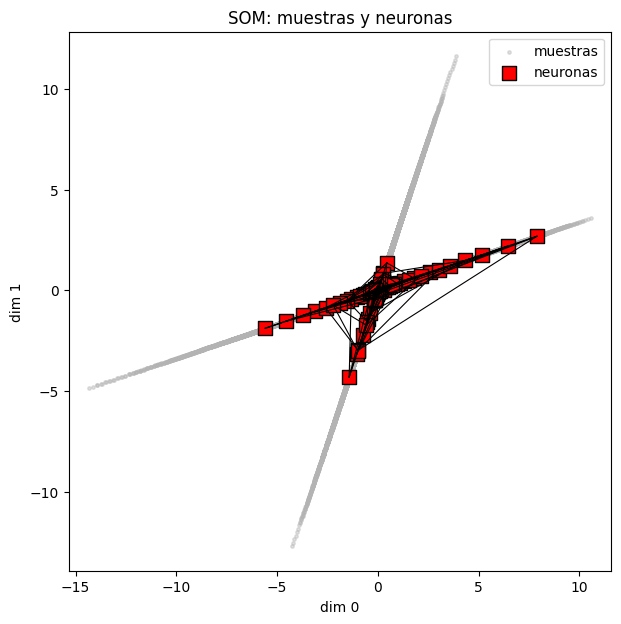

In [ ]:
# CELDA: visualización de muestras y neuronas del SOM

# obtener pesos de las neuronas (n_neurons, m_neurons, dim)
weights = som.get_weights()
w_reshaped = weights.reshape(-1, weights.shape[2])
plt.figure(figsize=(7,7))
# dibujar muestras (puntos)
plt.scatter(X[:,0], X[:,1], s=6, color='0.7', alpha=0.4, label='muestras')
# dibujar neuronas (cuadrados rojos)
plt.scatter(w_reshaped[:,0], w_reshaped[:,1], s=110, c='red', marker='s', edgecolor='k', label='neuronas')
# conectar vecinos en la malla para visualizar la topología
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        w = weights[i,j]
        if j+1 < weights.shape[1]:
            w2 = weights[i,j+1]
            plt.plot([w[0], w2[0]], [w[1], w2[1]], color='black', linewidth=0.8)
        if i+1 < weights.shape[0]:
            w2 = weights[i+1,j]
            plt.plot([w[0], w2[0]], [w[1], w2[1]], color='black', linewidth=0.8)
plt.legend()
plt.title('SOM: muestras y neuronas')
plt.xlabel('dim 0')
plt.ylabel('dim 1')
plt.axis('equal')
plt.show()